In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections #---> Library for operating with dictionaries
import random #---> Library for generating random numbers/distributions
import numpy as np #---> Library for efficiently operating with arrays/matrices/vectors
from pylab import rcParams #---> 
from operator import itemgetter 
 
import powerlaw
import seaborn as sns
import matplotlib.colors as mcolors
from itertools import count
import matplotlib.cm as cm
import community
import igraph
from collections import Counter
import matplotlib as mpl
import matplotlib.patches as patches
import random
import time

In [2]:
#Load the Network in a graph G
Gx = nx.read_edgelist('infect-dublin.edges.txt', nodetype=int, create_using=nx.Graph(),data=(('weight',float),))
print(nx.info(Gx))

Name: 
Type: Graph
Number of nodes: 410
Number of edges: 2765
Average degree:  13.4878


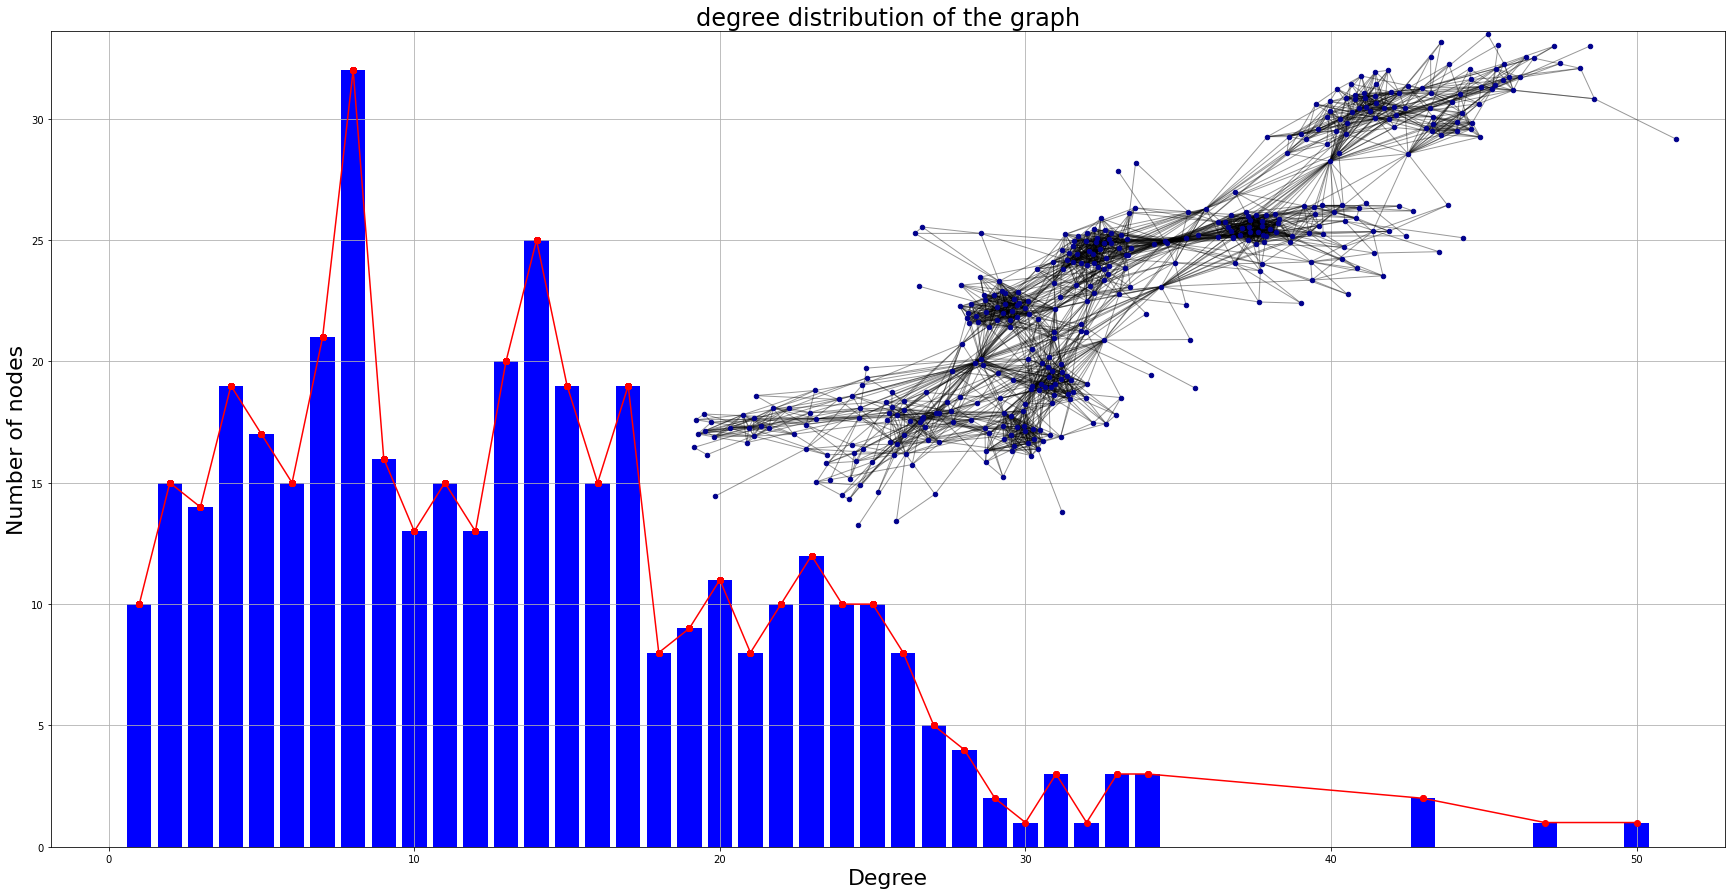

In [11]:
#Plot the Degree distribution of the graph

degrees = Gx.degree() 
#sort each node by degree
values = sorted([d for n, d in degrees])

out_set = set(values)


# building the histogram
hist = []
for x in out_set:
    cnt = values.count(x)
    for i in range(cnt):
        hist.append(cnt)

# ploting the degree distribution
plt.figure(figsize=(30, 15))
plt.grid(True)
plt.rc('font', size=15) 
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.plot(values, hist, 'ro-') # degree
plt.bar(values, hist, width=0.80, color='blue')
plt.xlabel('Degree',fontsize=22)
plt.ylabel('Number of nodes',fontsize=22)
plt.title('degree distribution of the graph',fontsize=24)

#Draw the network inside the barplot
plt.axes([0.4, 0.4, 0.5, 0.5])

#Select the largest connected component of the network:
Gcc = Gx.subgraph(sorted(nx.connected_components(Gx), key=len, reverse=True)[0])

pos = nx.spring_layout(Gx) #<-- Set the layout of the network
plt.axis('off') #<-- Remove the axis of the network plot
nx.draw_networkx_nodes(Gx, pos, node_color= 'darkblue',node_size=20) #<-- Plot the nodes
nx.draw_networkx_edges(Gx, pos, alpha=0.4) #<-- Plot the edges
plt.show()
plt.close()

Influencer Ego network .
The function Draw_ego_network that inputs a network G (a networkx network), a network layout (as
list of nodes position), and a node id and the maximum distance of interaction (as int). The function
Draw_ego_network will output the network plot of G outlining (with a different color and bigger size) the
node selected, and the ego network of the node id coloring in different color the links and the nodes depending
on the interaction distance.

In [4]:
#get the eigenvector centrality of the nodes
Centrality=nx.eigenvector_centrality(Gx)

#Find the node with highest centrality
key_val=list(Centrality.keys())
val=list(Centrality.values())
val=np.array(val)
idx=np.argsort(val)[-1]
max_node=key_val[idx]

Since we are visualizing the network as a Social Network let us imagine that each edge represents the concept of Following. So if any two nodes are connected by an edge they are following each other. To advertise a product we need to hire someone who has a large number of followers (i.e. edges), someone who is an influencer. Since our budget permits to hire only one influencer I suggest we hire an influencer who is well connected to other influencers, that way we will have better reach to more individuals in the entire network. I propose we hire the influencer (node) with highest Eigen vector centrality. The node having highest eigen vector centrality will be well connected to other nodes with high eigenvector centrality (influencers), so if our influencer advertises our product, the other influencers following our influencer might advertise as well and this way it will reach their followers (nodes). From the above code I found that node: 286 has highest eigenvector centrality hence it can be hired as an influencer to advertise the product.

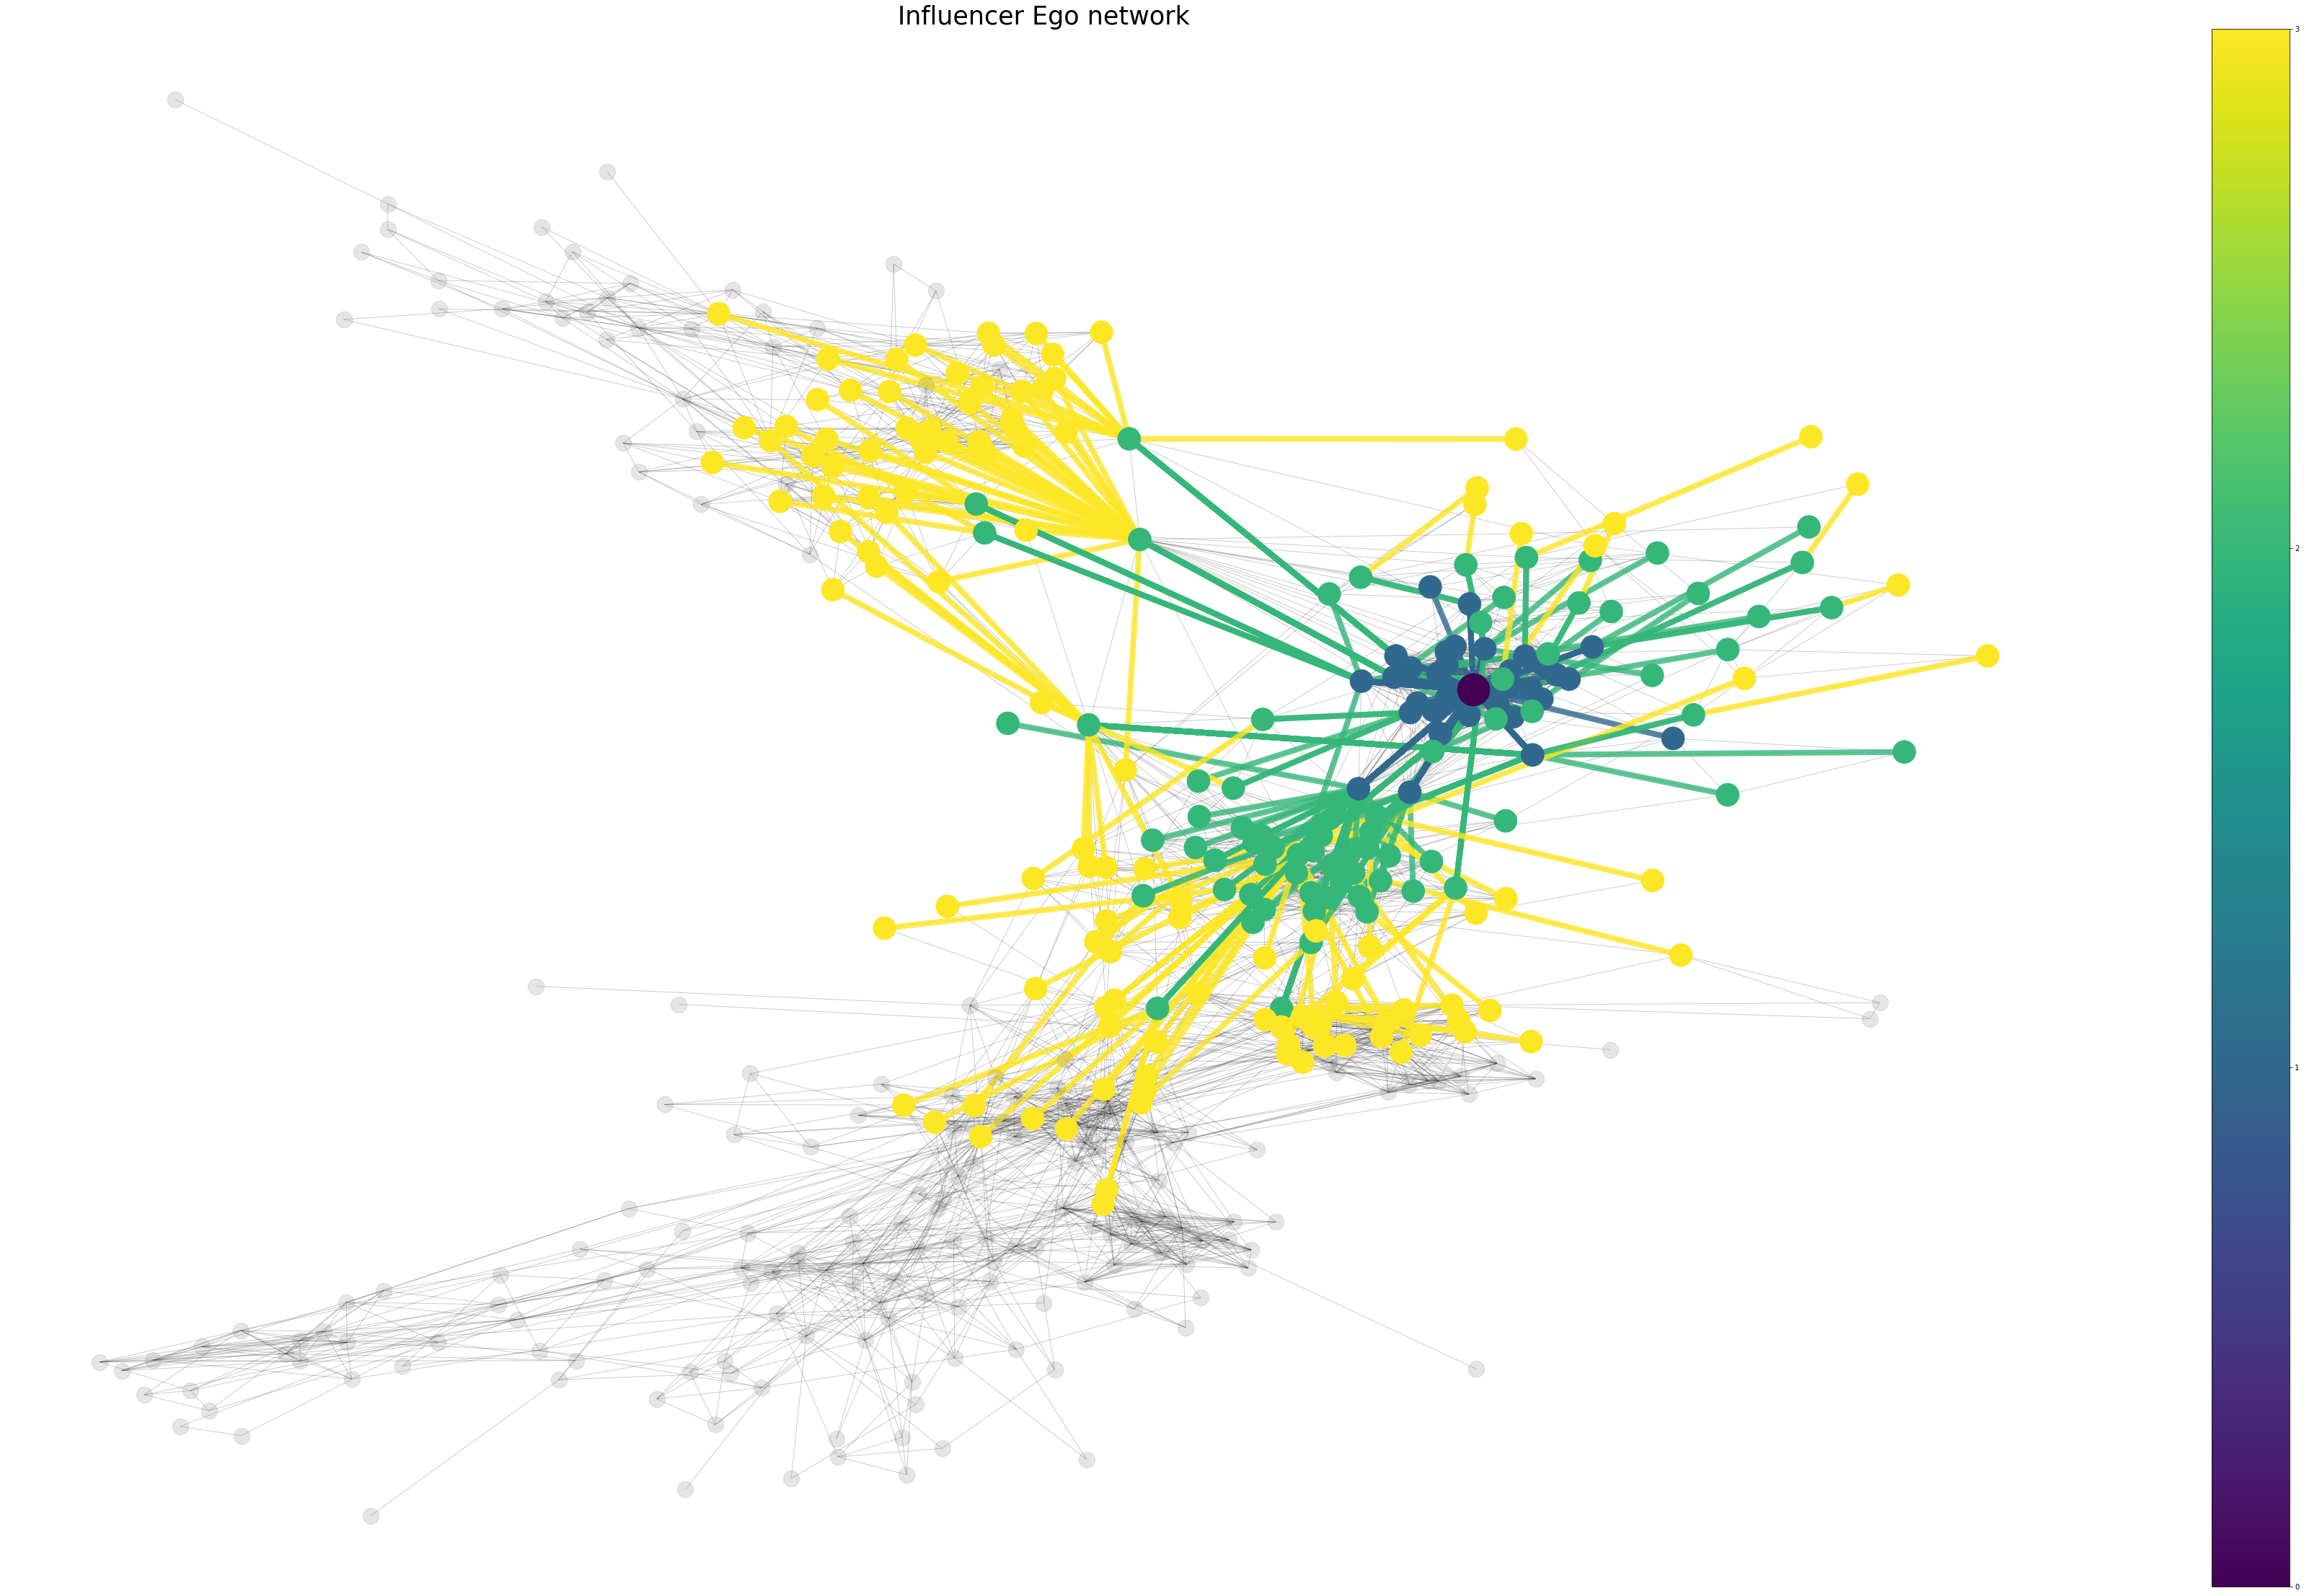

In [8]:
#Influencer Ego network
def get_colored_edges_nodes(Gx,max_node,d):
    
    #find the shortest path at a distance to maximum d from the ego centre
    
    path=nx.single_source_shortest_path(Gx, source = max_node, cutoff = d)
    
    keys=list(path.keys())
    vals=list(path.values())
    
    edges_list=[]
    nodes_list=[]
    edges_color=[]
    nodes_color=[]
    
    #the ego centre should have color 0
    nodes_list.append(keys[0])
    nodes_color.append(0)

    edges_list.append((max_node,max_node))
    edges_color.append(0)
    keys.pop(0)
    vals.pop(0)
    
    #Find the color of the nodes and edges based on the distance from the ego centre 
    
    for i in range(len(keys)):
        c=1
        nodes_list.append(keys[i])
        m=vals[i]
        for j in range(len(m)-1):
            
            edges_color.append(c)
            edges_list.append((m[j],m[j+1]))
            c+=1
        
        nodes_color.append(c-1) 
    
    
    return edges_list,edges_color,nodes_list,nodes_color,path
    


def Draw_ego_network(Gx,pos,max_node, d): 
    
    plt.figure(figsize = (50,30))
    
    nx.draw(Gx,pos,node_color='grey',node_size=500,alpha=0.2)
    
    edge_list,color,node_list,colors,path=get_colored_edges_nodes(Gx,max_node,d)
    
    
    
    norm = mcolors.Normalize(vmin = 0, vmax = d)
    smp = cm.ScalarMappable(norm=norm, cmap = cm.viridis)
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = colors, node_size = 1000)
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color=color,width=8,alpha=0.8)
    nx.draw_networkx_nodes(Gx, pos, node_size=2000, node_color=0, nodelist=[max_node])
    cbar = plt.colorbar(smp, )
    cbar.set_ticks(range(0, d+1))
    cbar.set_ticklabels(range(0, d+1))
    plt.axis('off')
    plt.title("Influencer Ego network",fontsize=35)
    plt.show()
    plt.close()
    return edge_list,color,node_list,colors,path   
    

pos=nx.spring_layout(Gx)
edge_list,color,node_list,colors,ego_network=Draw_ego_network(Gx,pos,max_node,3)    

Community Detection. Imagine that the graph G is now representing a topological map of distances between
the nodes. A link between any pair of nodes means that you can travel between the pair of nodes in a hour. If
a link is not present you can not travel between the nodes. You are been hired by a delivery agency to select
the perfect location for its new two garages. The delivery agency wants to start its business serving the two
biggest community of the network Gx based on the algorithm you decided. Where are you suggesting to build
the two garages (node id)? Which metric are you using to motivate you answer? Why? Plot the sub-network
of the two selected communities, with the metric you selected, outlining with different color and size the nodes
you proposed as garages’ locations.

By using the Lovain Community detection algorithm I have determined the two largest communities which are represented by cluster "Biggest community" and cluster "Second largest community" in the below plot. The nodes which do not belong to the two largest clusters are considered as Rest of topology.

Since the delivery agency wants to build garages to serve the two biggest communities, I would suggest they build garages at nodes: 236 and 302 as the garage locations. The garages should be placed in the communities in such way that they are close to the other nodes in that community in order to save energy and cost of travelling. For this reason the nodes with the highest Closeness Centrality within the respective communities can be chosen as the two garage locations.

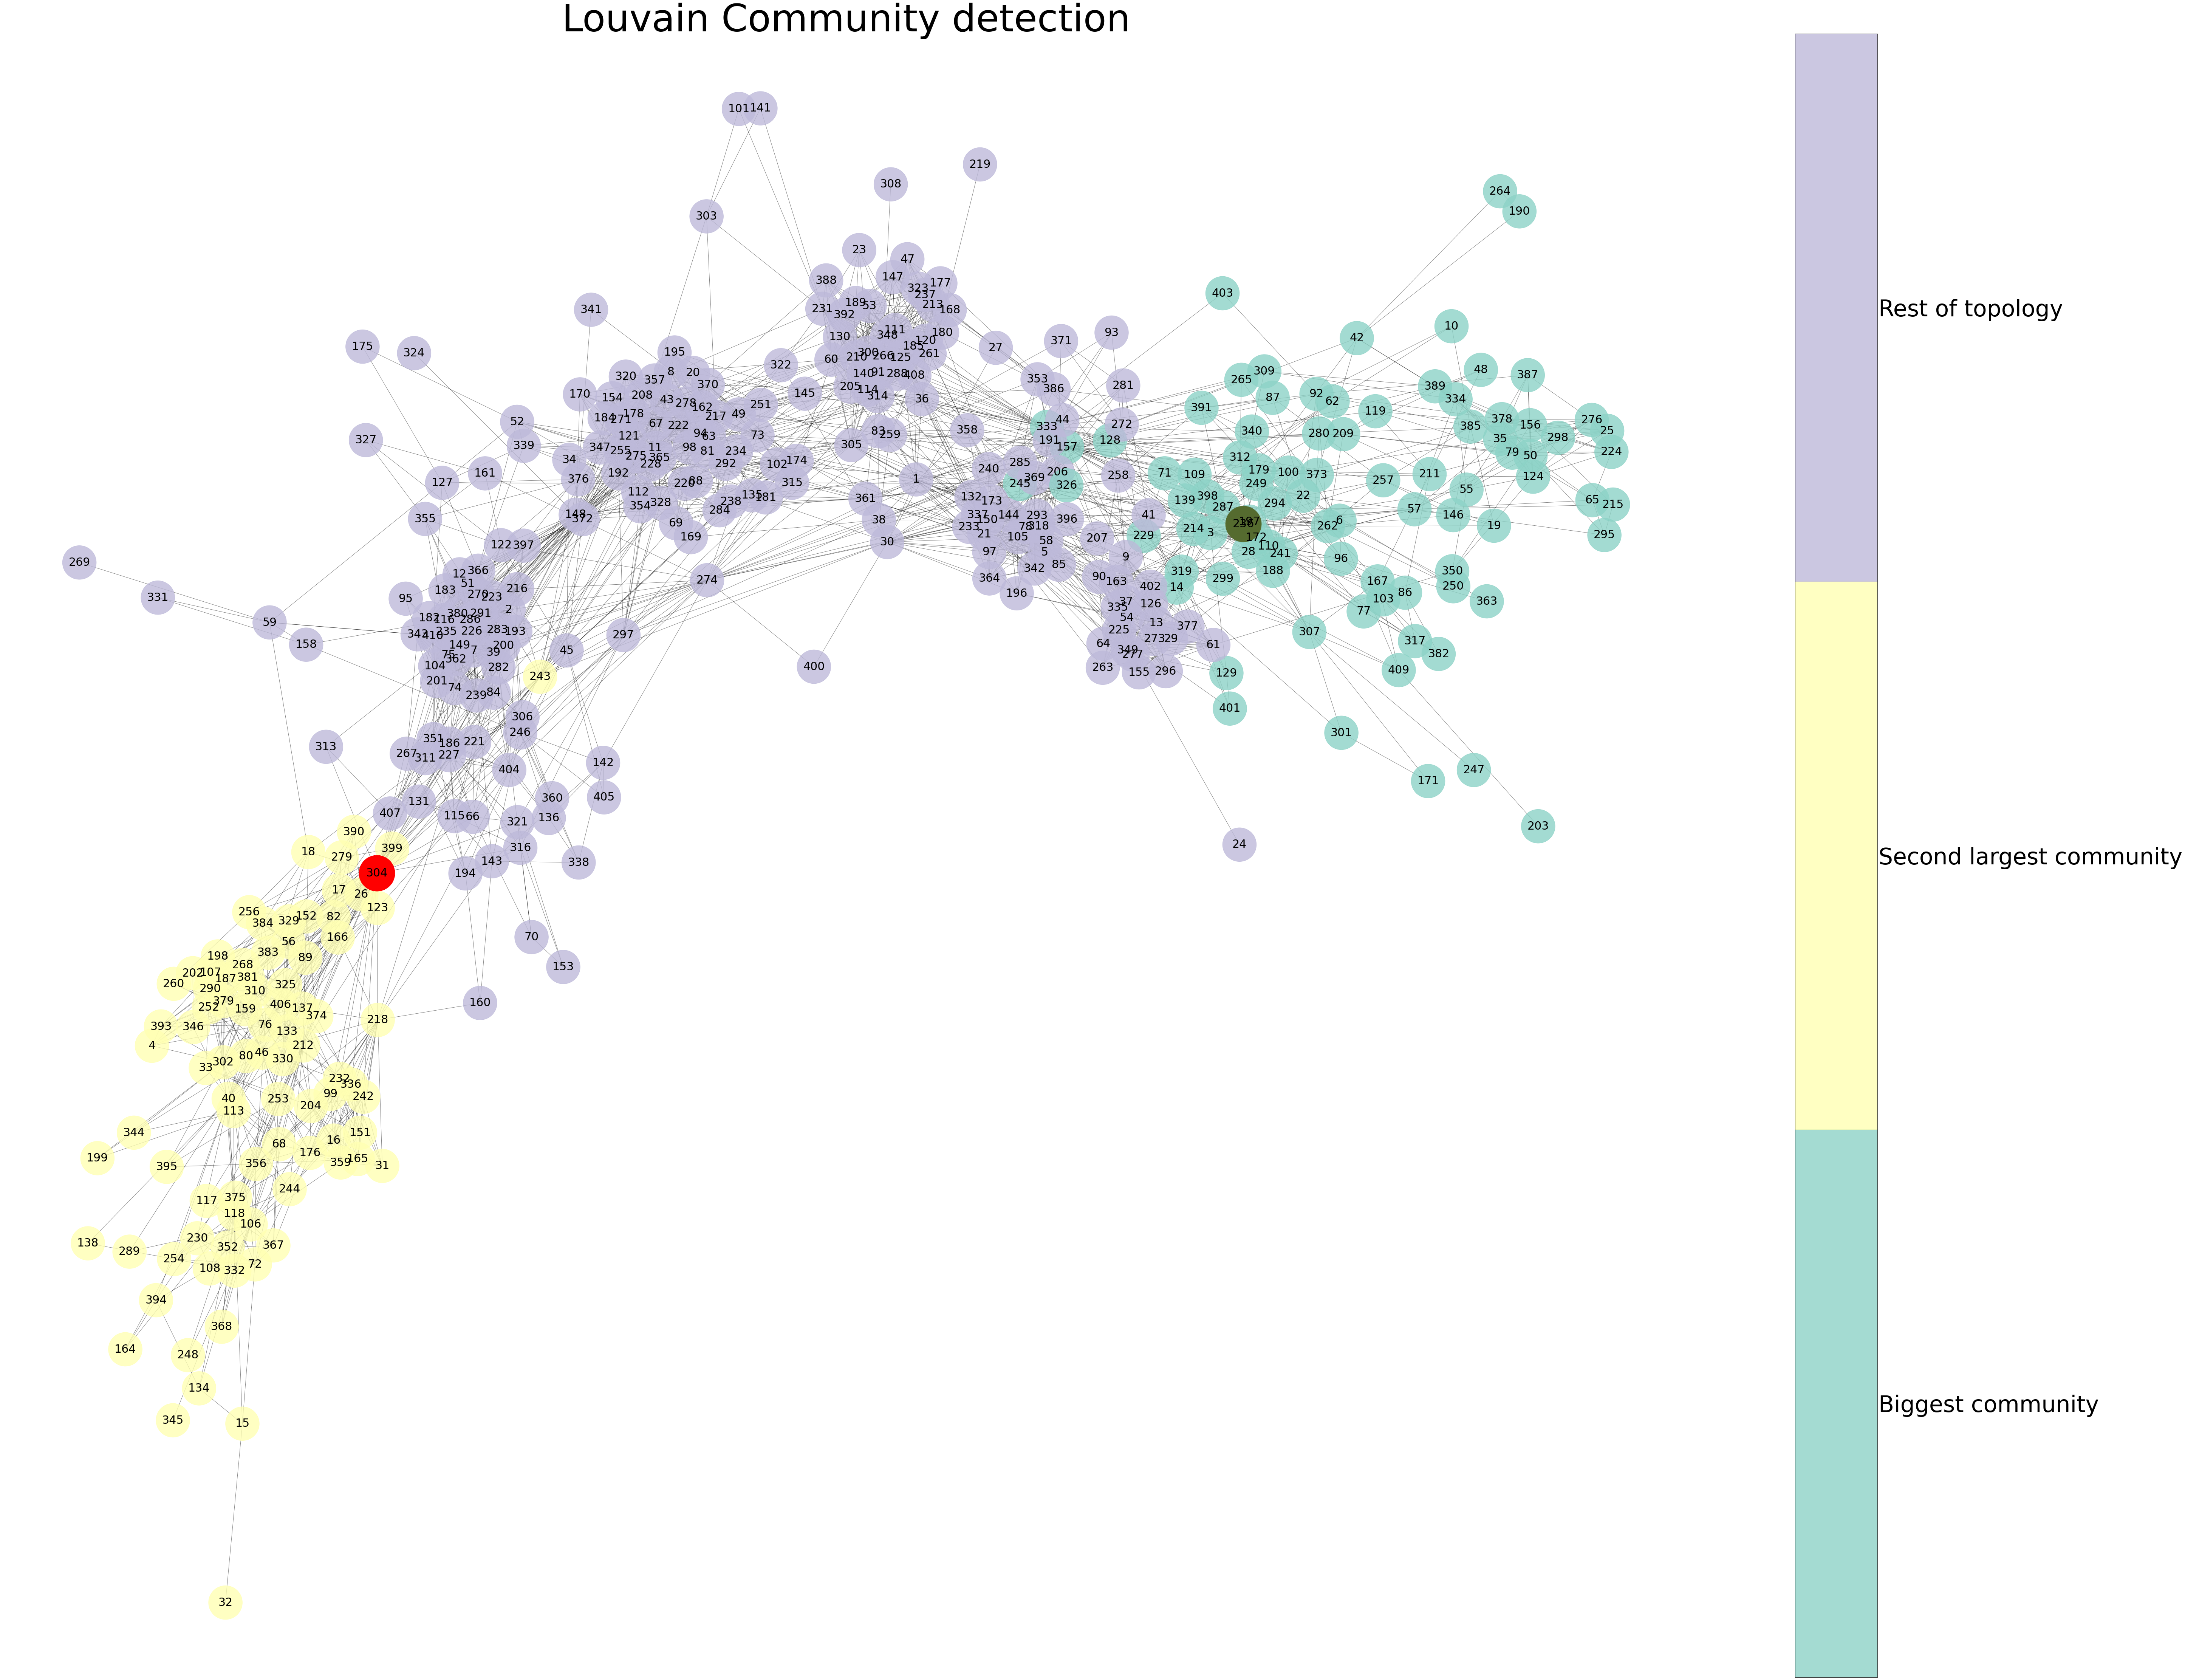

In [12]:


def draw_clu(G, pos, measures, measure_name,m1,m2):
  
    # Create an array to contain the clusters which have been found
    clusters=np.array(list(set(measures.values())))

    # Create a figure to draw the plots and charts
    plt.figure(figsize = (100,80))

    # Create the plot of the network to be placed in the figure
    nodes = nx.draw_networkx_nodes(G, pos, node_size=8000, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys()),alpha=0.8)

    nx.draw_networkx_nodes(G, pos, node_size=9000, node_color="darkolivegreen", nodelist=[m1],alpha=1.0)
    nx.draw_networkx_nodes(G, pos, node_size=9000, node_color="red", nodelist=[m2],alpha=1.0)
    # Add labels to the plot
    labels = nx.draw_networkx_labels(G, pos,font_size=30,alpha=1.0)

    # Add edges to the plot
    edges = nx.draw_networkx_edges(G, pos,alpha=0.5)

    # Create the title of the plot
    plt.title(measure_name,fontsize=100)

    # Add a colour bar to act as a legend
    cb = plt.colorbar(nodes,ticks=range(0,len(clusters)))
    cb.ax.tick_params(length=0)
    cb.ax.tick_params(labelsize= 60)
    # Adds the community labels to the colour bar
    #cb.set_ticklabels(list(set(measures.values())))
    cb.set_ticklabels(["Biggest community","Second largest community","Rest of topology"])


    nodes.set_clim(-0.5, len(clusters)-0.5)

    # Show the plot without the x/y axis
    plt.axis('off')
    plt.show()
    plt.close()


pos = nx.spring_layout(Gx)

G1=community.best_partition(Gx)
counts = Counter(G1.values())
#get the cluster with max nodes
comm1=max(counts, key=counts.get)
del counts[comm1]
#get the cluster with second highest number of nodes
comm2=max(counts, key=counts.get)
#find the nodes of the 2 largest clusters
nodes_comm1 = [k for k, v in G1.items() if v == comm1]
nodes_comm2=[k for k, v in G1.items() if v == comm2]
nodes_comm3=[k for k,v in G1.items() if (v!=comm1 and v!=comm2)]
#segregate the entire graph into 2 largest community and rest all in 3rd community
for n in nodes_comm3:
    G1[n]=-1
for n in nodes_comm1:
    G1[n]=0
for n in nodes_comm2:
    G1[n]=1
for n in nodes_comm3:
    G1[n]=2
    
#create sub graphs
G_comm1=Gx.subgraph(nodes_comm1)
G_comm2=Gx.subgraph(nodes_comm2)

#find the nodes for garage using closeness centrality for two communities

Centrality1=nx.closeness_centrality(G_comm1)

key_val1=list(Centrality1.keys())
val1=list(Centrality1.values())
val1=np.array(val1)
idx1=np.argsort(val1)[-1]
max_node1=key_val1[idx1]

Centrality2=nx.closeness_centrality(G_comm2)

key_val2=list(Centrality2.keys())
val2=list(Centrality2.values())
val2=np.array(val2)
idx2=np.argsort(val2)[-1]
max_node2=key_val2[idx2]

draw_clu(Gx, pos, G1,'Louvain Community detection',max_node1,max_node2 )